##### 1.torch.nn 概述

> torch.nn 是 torch 中构建神经网络的核心模块，它提供了网络层结构、激活函数、损失函数、容器与工具模块等，让我们能像搭积木一样快速定义和训练模型分为下面的四大板块：

- 1）网络层结构 layers：常见的主要为 nn.Linear、nn.Conv2d、nn.MaxPool2d、nn.BatchNorm2d、nn.RNN

- 2）激活函数 Activations：nn.ReLU、nn.sigmoid、nn.Tanh、nn.LeakyReLU

- 3）损失函数 Losses：nn.CrossEntropyLoss、nn.MSELoss、nn.BCELoss

- 4）容器与工具模块：nn.Sequential、nn.ModuleList、nn.Parameter、nn.Dropout

In [ ]:
import torch.nn as nn
import torch

fc = nn.Linear(in_features=1*28*28, out_features=10) # 全连接层，参数 bias 代表是否加上偏执，默认为 True

print(fc)
print(fc.parameters)
x_input = torch.randn(1, 1, 28, 28)
# [B, C, H, W]
x_input = x_input.view(1, -1)
print(x_input.shape)

x_output = fc(x_input)
print(x_output.shape)

Linear(in_features=784, out_features=10, bias=True)
<bound method Module.parameters of Linear(in_features=784, out_features=10, bias=True)>
torch.Size([1, 784])
torch.Size([1, 10])


##### 2.前置知识：\_\_call\_\_ 与 forward 的关系

In [3]:
class test:
    def __call__(self, x):
        print("forward test", x)
        return 

a = test()
print(a(5))

forward test 5
None


In [6]:
class test:
    def hello(self, x):
        print("forward test", x)
        return 
    
a = test()

# print(a(5))，执行这句话会对应下面的输出

# ---------------------------------------------------------------------------
# TypeError                                 Traceback (most recent call last)
# Cell In[4], line 7
#       4         return 
#       6 a = test()
# ----> 7 print(a(5))

# TypeError: 'test' object is not callable

- 1）上面的对比例子可以发现，其实实例直接传参是不合法的操作，但是 Python 类的内置 \_\_call\_\_ 函数的作用就是接受这样的参数，当传递的时候会执行这个类内的函数，而这个函数指向的就是 forward，这就是为什么直接用实例传到参数会执行类内的 forward 函数，所以构建的类要对 forward 函数进行实现

- 2）forward 在基类里面只是一个占位符，实现的继承类里面不写 forward 的话会抛出异常，也就是子类需要是实现他，而不是重写进行覆盖，和 Dataset 类延申的子类一样，Dataset 类内的 \_\_getitem\_\_ 函数也是没有实现的，但是也是必须要写的，在继承类里面需要实现

##### 3.nn.functional 的学习

> torch.nn.functional 简称 F 是 torch 内部的函数式的接口模块，提供了大量的构建神经网络时常用的计算函数，比如线性变换、卷积、池化、归一化、激活函数、损失函数等，这些函数不具备可学习参数，主要用于直接调用计算逻辑，而不是作为独立的层对象

> nn.Module 封装了参数（nn.Parameter）注册和前向计算的逻辑，torch.nn.functional 里面的函数本身不保存参数，允许手动传入参数，常见的 F 包里面的函数包含下面这些：

In [4]:
import torch.nn.functional as F

out = F.relu(x_output)
print(out.shape)
print(out)

out = F.sigmoid(x_output)
print(out.shape)
print(out)

out = F.leaky_relu(x_output, negative_slope=0.1) # 允许部分的负值漏出去的 relu，全部学习的话，直接看官方文档，或者用到再进行学习
print(out.shape)
print(out) 

out = F.tanh(x_output)
print(out.shape)
print(out)

torch.Size([1, 10])
tensor([[0.0000, 0.2187, 0.0000, 0.7493, 0.9664, 0.1724, 0.0259, 1.1358, 0.4785,
         0.0000]], grad_fn=<ReluBackward0>)
torch.Size([1, 10])
tensor([[0.3092, 0.5545, 0.3543, 0.6790, 0.7244, 0.5430, 0.5065, 0.7569, 0.6174,
         0.4005]], grad_fn=<SigmoidBackward0>)
torch.Size([1, 10])
tensor([[-0.0804,  0.2187, -0.0600,  0.7493,  0.9664,  0.1724,  0.0259,  1.1358,
          0.4785, -0.0403]], grad_fn=<LeakyReluBackward0>)
torch.Size([1, 10])
tensor([[-0.6661,  0.2153, -0.5372,  0.6347,  0.7471,  0.1707,  0.0259,  0.8130,
          0.4450, -0.3829]], grad_fn=<TanhBackward0>)


In [ ]:
a = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=float)
softmax = F.softmax(a, dim=-1)
print(softmax)

labels = torch.tensor([0, 0, 0]) # 将标签改为 [2, 2, 2] 损失就会变小一点，因为是第二类的概率更大
print(softmax.shape, labels.shape)
score = F.cross_entropy(softmax, labels)
print(score)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]], dtype=torch.float64)
torch.Size([3, 3]) torch.Size([3])
tensor(1.3724, dtype=torch.float64)


In [17]:
x = torch.tensor([[1, 2, 3, 4], [5, 6, 7, 8], [6, 7, 8, 9], [3, 4, 5, 6]], dtype=torch.float32)
x = x.reshape(1, 1, 4, 4) # [B, C, H, W]
w = torch.randn(2, 1, 3, 3) # [OC, IC, H, W]
print(x.shape)
print(w.shape)

# F.conv2d 很反直觉，他的 weight 的第一个参数是输出通道，nn.Conv2d 的先是输入通道的参数，虽然打印网络结构显示的输出通道在前但是很方便理解
out = F.conv2d(x, weight=w, bias=None, stride=1, padding=0)

print(out.sum(), out.mean(), out.std())
print(F.normalize(out, dim=3)) # 模长变为 1，dim=-1，第一个维度是 Batch
out = (out - out.mean()) / out.std() # 均值为 0，方差为 1
print(out.shape)

# 需要注意的是，多多的理解一下高位的矩阵的维度计算，三维还是能理解的，但是更高的维度就需要拓展了

torch.Size([1, 1, 4, 4])
torch.Size([2, 1, 3, 3])
tensor(-42.9939) tensor(-5.3742) tensor(5.0453)
tensor([[[[-0.5943, -0.8042],
          [-0.6227, -0.7825]],

         [[ 0.7745,  0.6326],
          [-0.6795, -0.7337]]]])
torch.Size([1, 2, 2, 2])


> 写到这里再次复述一下上面的重点问题，nn.Xxx 和 nn.functional.xxx 的实际功能是相同的，比图 nn.Cvn2d 和 nn.functional.cvn2d 都是进行卷积，运行效率也是相似的

- 1）很显然完全一样的话是不合理的，因为没必要两个库函数是完全一样的功能，主要的不同点的，nn.functional.xxx 是函数接口，nn.Xxx 是 nn.functional.xxx 的类封装，并且 nn.Xxx 都继承自同一个祖先 nn.Moudle

- 2）nn.Xxx 除了具有 nn.functional.xxx 的功能之外，内部还附有，nn.Moudle 相关的属性和方，eg. train()，eval()

- 3）形式上看，nn.functional.xxx 的函数是小写字母开头，nn.Xxx 是函数是大写字母开头

- 4）nn.functional.xxx 是 API 函数接口而 nn.Xxx 是对原先的 API 的类封装

- 5）所有的 nn.Xxx 都继承于共同的祖先 nn.Moudle，这一点导致了 nn.Xxx 除了具有 nn.functional.xxx 的功能之外，内部附带了 nn.Moudle 的相关属性和方法，例如上面提到的 train()，eval()

- 6）nn.Xxx 继承于 nn.Moudle 能很好的和 nn.Sequential 结合使用，但是 nn.functional.xxx 无法和 nn.Sequential 结合使用

- 7）nn.Xxx 需要先实例化并传入参数，然后以函数调用的方式调入实例化的对象并传入输入的数据，nn.functional.xxx 同时传入输入数据和 weight、bias 等其他的参数

- 8）nn.Xxx 不需要自己定义和管理 weight，但是 nn.functional.xxx 需要自己定义 weight，每次调用的时候需要手动传入，不利于代码的复用

> 当执行，nn.Conv2d 的时候，会先调用里面的初始化函数，初始化函数的第一行调用了 nn.Moudle 的初始化函数，nn.Moudle 初始化函数里面初始化 _parameters，_moudles 等容器，然后接着执行 Conv2d 的参数注册

In [18]:
# 伪代码
from collections import OrderedDict
class Conv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, ):
        super().__init__()
        self.weight = nn.Parameter(...)
        self.bias = nn.Parameter(...)

class Module:
    def __init__(self):
        self._parameters = OrderedDict()
        self._buffers = OrderedDict()
        self._modules = OrderedDict()
        self.training = True

> 上面是伪代码，继承 Module 的初始化是为了初始化框架，自己的初始化是为了保存参数，相比 nn.Xxx 函数 nn.functional.xxx 函数的参数需要自己来写非常的麻烦

- 1）创建 model 是时候，nn 会自动的创建相应的参数 parameter，并自动的累加到模型的 Parameter 成员列表里面

- 2）反向传播需要被更新的称之为 Parameters，不需要被更新的称之为 buffers

- 3）in_features 的数量，决定参数的个数，加上偏置，输入的维度为 in_features + 1，out_features 是数量，决定了全连接层中的神经元的个数，每个神经元只有一个输出

- 4）W 的总参数量是 in_features * out_features，b 的总参数量的 1 * out_features

> 下面介绍手动创建参数的办法，继承自 nn.Moudle 模型才会有注册列表，不注册的话不能参与梯度下降的优化，nn.Xxx 函数会自动的注册当前的参数到注册表里面，不用显式的定义出类下面的 w 矩阵

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Linear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.w = nn.Parameter(torch.randn(out_features, in_features))
        self.b = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        return F.linear(x, self.w, self.b)

model = Linear(3, 1)

# 查看注册的参数列表
for name, param in model.named_parameters():
    print(name, param.shape, param.requires_grad)


x_input = torch.tensor([[1., 1., 1.]])
x_input = x_input.reshape(3, 1)

w = torch.randn((3, 1))

print(w.requires_grad)  # False
w = nn.Parameter(w)
b = nn.Parameter(torch.randn(3))
print(w.requires_grad)  # True

print(x_input.shape, w.shape)

fc = F.linear(x_input, weight=w, bias=b)
print(fc)

w torch.Size([1, 3]) True
b torch.Size([1]) True
False
True
torch.Size([3, 1]) torch.Size([3, 1])
tensor([[-2.5177,  1.8410, -1.3470],
        [-2.5177,  1.8410, -1.3470],
        [-2.5177,  1.8410, -1.3470]], grad_fn=<AddmmBackward0>)


##### 4.nn.Module 的学习

> nn.Module 是 torch 所有组件的共同祖先，他既可以是一层 nn.Conv2d 也可以是很多层组成的模型，完全取决于自定义的 mynet，所有的层/模型都继承自他，比如 

- 1）Conv2d、Linear、BantchNorm、Sequential 容器和机制也是由他负责，管理与训练相关的对象，比如 Parameter（可训练参数）、buffer（非可训练但是要随着模型保存的张量）

- 2）递归管理子模块，设备迁移，精度变换，训练和评估模式的转换等，还有前向调用协议 \_\_call\_\_ 调用到 forward 等

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MyBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 3, padding=0) # [output_channels, input_channels, kernels, ...]
        # 注册一个 buffer（非训练参数，但要随模型保存/迁移）
        self.register_buffer("coord_bias", torch.zeros(1, out_ch, 1, 1)) # 从后往前（右对齐）比维度，只要每一对对应维度相等，或其中一个为 1，就能广播

    def forward(self, x):
        out = self.conv(x) + self.coord_bias # buffer 参与前向，但不被优化
        print(out.shape)
        return out

class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = MyBlock(3, 16)
        self.head = nn.Linear(16*8*8, 10)

    def forward(self, x):
        x = self.block1(x) # 模块嵌套
        x = F.adaptive_avg_pool2d(x, (8,8))
        x = x.flatten(1)
        return self.head(x) # 调用线性层

net = MyNet()
print(net)

ipt = torch.randn(16, 3, 224, 224)
print(net(ipt).shape)

for n, p in net.named_parameters():
    print(n, p.shape, p.requires_grad)

for n, b in net.named_buffers():
    print(n, b.shape)

print("----------------------------")
sd = net.state_dict()

for k, v in sd.items(): # for x in sd 假设 sd 是一个字典的话，只会迭代字典的键，等价于 for x in sd.keys()，得带键值需要用 items()
    print(k, v.shape)


MyNet(
  (block1): MyBlock(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  )
  (head): Linear(in_features=1024, out_features=10, bias=True)
)
torch.Size([16, 16, 222, 222])
torch.Size([16, 10])
block1.conv.weight torch.Size([16, 3, 3, 3]) True
block1.conv.bias torch.Size([16]) True
head.weight torch.Size([10, 1024]) True
head.bias torch.Size([10]) True
block1.coord_bias torch.Size([1, 16, 1, 1])
----------------------------
block1.coord_bias torch.Size([1, 16, 1, 1])
block1.conv.weight torch.Size([16, 3, 3, 3])
block1.conv.bias torch.Size([16])
head.weight torch.Size([10, 1024])
head.bias torch.Size([10])


In [24]:
def parameters(self, recurse=True):
    for _, param in self.named_parameters(recurse=recurse):
        yield param
# model.parameters 只返回参数值不返回名字，model.named_parameters 返回名字和对象二者的关系可以大致看作上面函数展示的样子

# 前者常用于传递个优化器的优化 optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# 后者常用于打印观察参数列表

> 定义的输入维度在前输出维度在后输出的参数列表就相反了的原因是，定义的时候写 (in, out) 更自然，如果反过来定义（nn.Linear(out, in)），虽然形状对，但语义不自然，在神经网络设计中我们总是思考“输入几维输出几维”，所以构造函数写 (in_features, out_features) 更符合人类直觉。torch 内部再自动转成 [out, in] 的存储方式，所以输出参数矩阵的时候就是反的了，因为计算的时候需要转置，存储就是输出在前

##### 5.nn.Sequential 的学习

> 下面介绍 nn.Sequential 构建神经网络的一般步骤，上面讲解了 nn.Module 还有常见的层的组件，现在把他们串在一起，很想 transforms 里面的 Compose，

> nn.Sequential 是一个有序的容器，该类将按照传入构造器的顺序，依次创建相应的函数，并记录在 Sequential 类对象的数据结构中，同时以神经网络模块为元素的有序字典也可以作为传入参数，因此，Sequential 可以看成是有多个函数运算对象，串联成的神经网络，其返回的是 Module 类型的神经网络对象

In [26]:
ipt = torch.randn(16, 28*28)

model = nn.Sequential(
    nn.Linear(28*28, 32),
    nn.ReLU(),
    nn.Linear(32, 3),
    nn.Softmax(dim=1)
)
print(type(model))
print(model)
print(model(ipt))

<class 'torch.nn.modules.container.Sequential'>
Sequential(
  (0): Linear(in_features=784, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=3, bias=True)
  (3): Softmax(dim=1)
)
tensor([[0.3812, 0.2429, 0.3759],
        [0.4023, 0.3383, 0.2594],
        [0.3767, 0.3755, 0.2478],
        [0.3486, 0.3443, 0.3071],
        [0.3528, 0.3314, 0.3158],
        [0.4175, 0.3088, 0.2737],
        [0.3992, 0.2822, 0.3186],
        [0.3670, 0.3996, 0.2334],
        [0.3729, 0.3966, 0.2305],
        [0.3876, 0.3242, 0.2882],
        [0.3628, 0.3686, 0.2686],
        [0.4166, 0.3039, 0.2795],
        [0.2780, 0.5035, 0.2185],
        [0.4222, 0.3325, 0.2453],
        [0.2799, 0.5105, 0.2095],
        [0.2649, 0.3704, 0.3647]], grad_fn=<SoftmaxBackward0>)


In [27]:
# def forward(self, x):
#     for module in self._modules.values():
#         x = module(x)
#     return x
# nn.Sequential 内部做的事情比较简单，上面就是，但是其只是简单的串联适用于简单的线性堆叠网络

- 1）适合用 Sequential 的情况：网络结构简单，不需要多输入、多分支，每一层依次执行，典型场景为多层感知机（MLP）、普通卷积堆叠

- 2）不适合 Sequential 的情况：网络有跳跃连接（skip connection），有多输入或多输出，有条件执行逻辑（如 if/else 或循环），需要自定义中间变量或计算统计量

In [15]:
# 也可以以字典的形式，串联函数运算，构建串行执行的神经网络
from collections import OrderedDict
import torch.nn as nn

model = nn.Sequential(OrderedDict([
    ('h1', nn.Linear(28*28, 32)),
    ('relu1', nn.ReLU()),
    ('h2', nn.Linear(32, 10)),
    ('softmax', nn.Softmax(dim=1))
]))

print(type(model))
print(model)

<class 'torch.nn.modules.container.Sequential'>
Sequential(
  (h1): Linear(in_features=784, out_features=32, bias=True)
  (relu1): ReLU()
  (h2): Linear(in_features=32, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)


##### 6.自定义神经网络

> 最后讲解的就是自定义神经网络了，也就是继承 nn.Module 类，继承的原因的，需要注册到参数列表还有，初始化参数列表，可使用相关的方法和函数等

- 1）函数都要加上 self 是原因是，当执行 model = TestNet()，创建实例之后，执行 model(23, 32)，其实执行的是 TestNet(model, 23, 32)，也就是将实例对象作为第一个参数传进去了

- 2）不创建实例的话，直接使用 TestNet(10, 32)，初始化和其他的函数就不用加上 self 了，但是 torch 要求一定要实例化的 model 才能调用其相关的函数，不实例化每次 .parameters 都是新的参数，没办法训练

- 3）\_\_init\_\_ 创建实例的时候就执行了，\_\_call\_\_ 引导的 forward 需要 model(x) 的时候才会执行

In [28]:
class TestNet(nn.Module):
    def __init__(self, input_channels, output_channels):
        super().__init__()
        self.hidden_channels = input_channels * 4
        self.linear1 = nn.Linear(input_channels, self.hidden_channels)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(self.hidden_channels, output_channels)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, x):
        print(x.size())
        x = x.view(x.size()[0], -1)
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x

model = TestNet(28*28, 32)
print(model.parameters)
x_input = torch.randn(2, 1, 28, 28)
x_output = model(x_input)
print(x_output.shape)

<bound method Module.parameters of TestNet(
  (linear1): Linear(in_features=784, out_features=3136, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=3136, out_features=32, bias=True)
  (softmax): Softmax(dim=1)
)>
torch.Size([2, 1, 28, 28])
torch.Size([2, 32])


> 一些没讲到的常见函数：

- 1）torch.save(model.state_dict(), 'model.pth')

- 2）model.load_state_dict(torch.load('model.pth'))

- 3）torch.save(model, 'model_complete.pth')

- 4）device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

- 5）model = model.to(device)

In [ ]:
# 梯度检查
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.grad}")

# 冻结某些层
for param in model.linear1.parameters():
    param.requires_grad = False

# 自定义层，注册到参数列表
class MyCustomLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_features, in_features)) # 需要注册的原因是不是使用的 nn.Xxx 层的函数

    def forward(self, x):
        return x @ self.weight.t()

# 残差连接
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
    
    def forward(self, x):
        residual = x
        x = F.relu(self.conv1(x))
        x = self.conv2(x)
        return F.relu(x + residual) # 残差连接，因为 ReLU 没有可学习参数（不像 BatchNorm 或 Conv），所以用函数式或模块式都可以
# 构建 Sequential 的时候建议使用 nn.ReLU()，想要打印完整结构的时候需要使用 nn.ReLU()
# 只有在 __init__ 里定义为子模块或参数的内容，才会被注册（出现在 model 输出结构里），forward() 里的中间操作不会被注册或打印，只是执行时的计算逻辑

model = ResidualBlock(3)
print(model)

# 批量归一化和 dropout
class NetWithBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 10)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        return self.fc2(x)

linear2.weight: None
linear2.bias: None
ResidualBlock(
  (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


##### 7.实验

torch.Size([300, 1])
torch.Size([300])
Epoch:   0 | Loss: 1.1957
Epoch:  50 | Loss: 0.3969
Epoch: 100 | Loss: 0.2838
Epoch: 150 | Loss: 0.2272
Epoch: 200 | Loss: 0.1941
Epoch: 250 | Loss: 0.1748


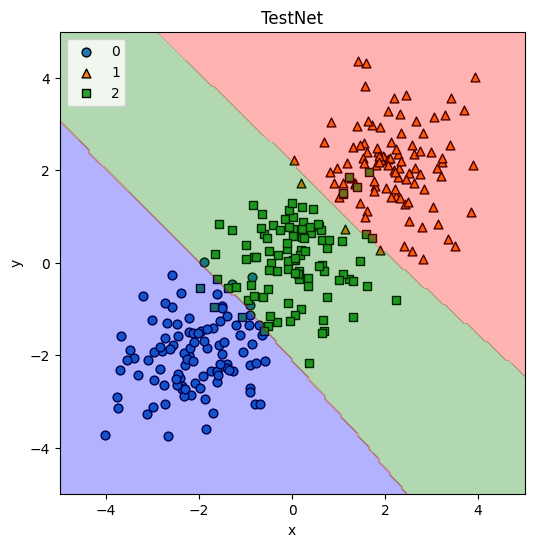

In [35]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

n_samples = 100
x_class0 = torch.randn(n_samples, 2) * 0.8 + torch.tensor([-2., -2.])
x_class1 = torch.randn(n_samples, 2) * 0.8 + torch.tensor([2., 2.])
x_class2 = torch.randn(n_samples, 2) * 0.8

x = torch.cat([x_class0, x_class1, x_class2], dim=0)
y = torch.cat([torch.zeros(n_samples, 1), torch.ones(n_samples, 1), torch.ones(n_samples, 1) * 2], dim=0)
print(y.shape)
y = y.squeeze().long()
print(y.shape)

model = nn.Sequential(
    nn.Linear(2, 8),
    nn.ReLU(),
    nn.Linear(8, 3)
    # nn.Softmax(dim=1) 交叉熵会自动计算 Softmax，不需要加上这个
)

criterion = nn.CrossEntropyLoss()

for epoch in range(300):
    y_pred = model(x)

    loss = criterion(y_pred, y)
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p -= 0.1 * p.grad
    if epoch % 50 == 0:
        print(f"Epoch: {epoch:3d} | Loss: {loss.item():.4f}")

plt.figure(figsize=(6, 6))
colors = ['blue', 'red', 'green']
labels = ['0', '1', '2']
markers = ['o', '^', 's']

for i in range(3):
    plt.scatter(
        x[y == i, 0], # y == i 返回当前类别为 i 的所有点的 bool 矩阵 [True, False, ....]，x[:, 0]，取出所有点的横坐标，x[y ==i, 0] 取出满足条件的点的横坐标
        x[y == i, 1],
        # c=colors[i],
        marker=markers[i],
        label=labels[i],
        edgecolors='k',
        s=40
    )

xx, yy = torch.meshgrid(
    torch.linspace(-5, 5, 200),
    torch.linspace(-5, 5, 200),
    indexing='xy'
)

grid = torch.stack([xx.flatten(), yy.flatten()], dim=1)

with torch.no_grad():
    logits = model(grid)
    preds = logits.argmax(dim=1)
    preds = preds.reshape(xx.shape)

plt.contourf(xx, yy, preds, levels=[-0.5, 0.5, 1.5, 2.5], alpha=0.3, colors=colors)

plt.legend()
plt.title('TestNet')
plt.xlabel('x')
plt.ylabel('y')
plt.show()